# Time series forecasting using Recurrent Neural Networks (RNNs).

Let's first extract only the 'cases ' from the dataset. Let's observe how this data looks across time.

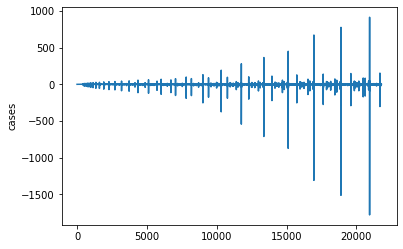

In [5]:
import os
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('C:\\Users\\Mirela\\PycharmProjects\\Covid_19\\us-counties.csv',
                      usecols=[5]).values.astype('float64')


def delta_time_series(data):
# Shift features and labels one step relative to each other
    return data[1:]- data[:-1]

dataset = delta_time_series(dataset)

dataset.shape

def plot_delta(data):
    plt.plot(delta_time_series(data))
    plt.ylabel('cases')
    plt.show()
    
plot_delta(dataset)  

In [6]:
# Helper function to get y as a numpy array from the TimeseriesGenerator
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

The first 16,000 rows of the data will be the training dataset, and there remaining will be the validation  and  test dataset .
It is important to scale features before training a neural network. Standardization is a common way of doing this scaling by subtracting the mean and dividing by the standard deviation of each feature.
The model will be given the last 100 recorded 'cases' observations, and needs to learn to predict the cases at the next time step.

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets

train, val, test = dataset[0:16000, :], dataset[16001:17000, :], dataset[17001:None, :]

lookback = 100
step = 1
batch_size = 128

train_data_gen = TimeseriesGenerator(train, train,
                                     length=lookback, sampling_rate=step, stride=1,shuffle=True,
                                     batch_size=batch_size)

val_data_gen = TimeseriesGenerator(val, val,
                                   length=lookback, sampling_rate=step, stride=1,
                                   batch_size=batch_size)

test_data_gen = TimeseriesGenerator(test, test,
                                    length=lookback, sampling_rate=step, stride=1,
                                    batch_size=batch_size)

val_steps = (17000 - 16001 - lookback)
test_steps = (len(dataset) - 17001 - lookback)

I  will train a model using only a single feature (cases), and use it to make predictions for that value in the future.

Epoch 1/10
200/200 [==============================] - 27s 133ms/step - loss: 0.0543 - val_loss: 0.0306
Epoch 2/10
200/200 [==============================] - 28s 139ms/step - loss: 0.0151 - val_loss: 0.0130
Epoch 3/10
200/200 [==============================] - 26s 131ms/step - loss: 0.0119 - val_loss: 0.0079
Epoch 4/10
200/200 [==============================] - 28s 139ms/step - loss: 0.0102 - val_loss: 0.0050
Epoch 5/10
200/200 [==============================] - 34s 172ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 6/10
200/200 [==============================] - 34s 170ms/step - loss: 0.0085 - val_loss: 0.0017
Epoch 7/10
200/200 [==============================] - 35s 173ms/step - loss: 0.0081 - val_loss: 0.0013
Epoch 8/10
200/200 [==============================] - 34s 169ms/step - loss: 0.0077 - val_loss: 7.5571e-04
Epoch 9/10
200/200 [==============================] - 33s 167ms/step - loss: 0.0075 - val_loss: 6.1018e-04
Epoch 10/10
200/200 [==============================] - 32s 159ms/

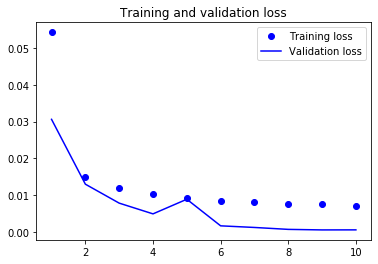

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2,input_shape=(None, dataset.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_data_gen,steps_per_epoch=200,epochs=10,validation_data=val_data_gen,
validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

test loss: 0.0008021448738873005
(4697, 1)
Test Score: 0.01 RMSE


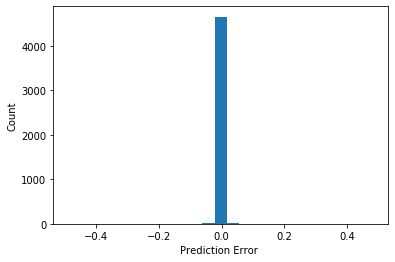

In [9]:
test_loss = model.evaluate_generator(test_data_gen,steps=test_steps)
print('test loss:', test_loss)

testPredict = model.predict_generator(test_data_gen)
testPredict.shape


testY = get_y_from_generator(test_data_gen)


from sklearn.metrics import mean_squared_error
import math
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# error distribution
error = testPredict - testY
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")